In [1]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl

import os
from collections import defaultdict

import io

In [2]:
def set_paramters (filepath):
    with open(filepath) as file:
        for line in file:
            if line.startswith("#m="):
                global m
                m = float(line.strip()[3:])
            elif line.startswith("#A="):
                global a
                a = int(line.strip()[3:])
            elif line.startswith("#H="):
                global h
                h = int(line.strip()[3:])
            elif line.startswith("#rH2="):
                global rh2
                rh2 = float(line.strip()[5:])
            elif line.startswith("#Rp2="):
                global rp2
                rp2 = float(line.strip()[5:])
            elif line.startswith("#RC2="):
                global rc2
                rc2 = float(line.strip()[5:])
            else:
                break



def set_parameters_manually (m_, a_, h_, rh_sqr_, rp_sqr_, rc_sqr_):
    global m
    m = m_
    
    global a
    a = a_
    
    global h
    h = h_

    global rh2
    rh2 = rh_sqr_

    global rp2
    rp2 = rp_sqr_

    global rc2
    rc2 = rc_sqr_



def files_with_same_parameters (directory):
    matching_files = list()
    for filename in os.listdir(directory):
        with open(directory+filename, 'r') as file:
            for line in file:
                if line.startswith("#m="):
                    if (m != float(line.strip()[3:])):
                        break
                elif line.startswith("#A="):
                    if (a != int(line.strip()[3:])):
                        break
                elif line.startswith("#H="):
                    if (h != int(line.strip()[3:])):
                        break
                elif line.startswith("#rH2="):
                    if (rh2 != float(line.strip()[5:])):
                        break
                elif line.startswith("#Rp2="):
                    if (rp2 != float(line.strip()[5:])):
                        break
                elif line.startswith("#RC2="):
                    if (rc2 != float(line.strip()[5:])):
                        break
                elif line.startswith("##"):
                    matching_files.append(directory+filename)
                    break
    return matching_files



def find_different_values (any_all):
    values = []
    for value in any_all[0]:
        if value not in values:
            values.append(value)
    
    return values



def read_data_from_files (file_list):
    print(f"Reading from {len(file_list)} files")

    delta_all = []
    q_all = []
    phi_all = []
    a_real_all = []
    a_imag_all = []
    b_all = []
    hotspot_pos_all = []

    # Loop through each file in the directory
    for filename in file_list:
        delta_array = []
        q_array = []
        phi_array = []
        a_real_array = []
        a_imag_array = []
        b_array = []
        hotspot_pos_array = []
        hotspot_pos_entry = []
        line_is_hotspot_pos = False

        with open(filename, 'r') as file:
            # Read data from the file and store it in the dictionary
            for line in file:
                if line.startswith('#Nucleon') and not line_is_hotspot_pos:
                    line_is_hotspot_pos = True
                elif line_is_hotspot_pos:
                    if line.startswith('#Nucleon'):
                        hotspot_pos_array.append(hotspot_pos_entry)
                        hotspot_pos_entry = []
                    elif line.startswith('##'):
                        hotspot_pos_array.append(hotspot_pos_entry)
                        line_is_hotspot_pos = False
                        hotspot_pos_entry = []
                    else:
                        x1, x2 = map(str, line.strip().split(' '))
                        x1 = x1.replace('#', '')
                        hotspot_pos_entry.append( { 'x1':float(x1), 'x2':float(x2) } )

                elif (line == "\n"):
                    continue
                elif line.startswith("#"):
                    continue
                else:
                    numbers = line.strip().split("   ")
                    delta, q = map(float, numbers[0].strip().split(" "))
                    
                    phi_array.clear()
                    # these will contain the values for one Delta and Q but all phi
                    a_real_vals = []
                    a_imag_vals = []
                    b_vals = []

                    for i in range(1, len(numbers)):
                        phi, a_real, a_imag, b = map(float, numbers[i].strip().split(" "))
                        
                        phi_array.append(phi) # these will have length num_phi_vals
                        a_real_vals.append(a_real)
                        a_imag_vals.append(a_imag)
                        b_vals.append(b)

                    delta_array.append(delta) # these have length num_delta_vals*num_q_vals
                    q_array.append(q)
                    a_real_array.append(a_real_vals)
                    a_imag_array.append(a_imag_vals)
                    b_array.append(b_vals)
        
        delta_all.append(delta_array) # these have length num_events
        q_all.append(q_array)
        phi_all.append(phi_array)
        a_real_all.append(a_real_array)
        a_imag_all.append(a_imag_array)
        b_all.append(b_array)
        hotspot_pos_all.append(hotspot_pos_array)
    
    len_store = len(q_all[0])

    #checking if Q values are the same for all files
    for q_vals in q_all:
        if len(q_vals) != len_store:
            print("Some files do not have the same number of data points (Q)!")
            exit()

    for q_index in range( len(q_all[0]) ):
        q_store = q_all[0][q_index]
        for event_index in range( len(q_all) ):
            if q_store != q_all[event_index][q_index]:
                print("Q values are not the same for some of the files!")
                exit()

    for delta_vals in delta_all:
        if len(delta_vals) != len_store:
            print("Some files do not have the same number of data points (Delta)!")
            exit()

    for delta_index in range( len(delta_all[0]) ):
        delta_store = delta_all[0][delta_index]
        for event_index in range( len(delta_all) ):
            if delta_store != delta_all[event_index][delta_index]:
                print("Delta values are not the same for some of the files!")
                exit()

    len_store = len(phi_all[0])
    for phi_vals in phi_all:
        if len(phi_vals) != len_store:
            print("Some files do not have the same number of data points (phi)!")
            exit()

    for phi_index in range(len(phi_all[0])):
        phi_store = phi_all[0][phi_index]
        for event_index in range(len(phi_all)):
            if phi_all[event_index][phi_index] != phi_store:
                print(f"Not all phi values from all files match.\nFile with name {file_list[event_index]} does not match the previous ones.")
                exit()

    all_dict = {
                'Delta': delta_all,
                'Q': q_all,
                'phi': phi_all,
                'A_real': a_real_all,
                'A_imag': a_imag_all,
                'B': b_all,
                'Hotspot': hotspot_pos_all,
            }
    
    return all_dict



def calculate_cs (all_dict):
    cs_results = []
    cs_results_different_phi = []

    q_values = find_different_values(all_dict['Q'])
    delta_values = find_different_values(all_dict['Delta'])
    phi_values = find_different_values(all_dict['phi'])

    num_events = len(all_dict['Delta'])
    print(f"Data from {num_events} events")

    num_values = len(all_dict['Delta'][0])


    for phi_index in range(len(phi_values)):
        phi = phi_values[phi_index]

        cs_results_single_phi = []


        t_values = []

        a_real_avg_of_sqrs_values = []
        a_imag_avg_of_sqrs_values = []

        a_real_sqr_of_avg_values = []
        a_imag_sqr_of_avg_values = []

        a_avg_of_sqrs_values = []
        a_sqr_of_avg_values = []
        b_avg_values = []
        inco_values = []

        a_real_avg_of_sqrs_err_values = []
        a_imag_avg_of_sqrs_err_values = []

        a_real_sqr_of_avg_err_values = []
        a_imag_sqr_of_avg_err_values = []

        a_avg_of_sqrs_err_values = []
        a_sqr_of_avg_err_values = []
        b_avg_err_values = []
        inco_err_values = []


        for delta in delta_values:
            a_real_avg_of_sqrs = 0.0
            a_imag_avg_of_sqrs = 0.0

            a_real_sqr_of_avg = 0.0
            a_imag_sqr_of_avg = 0.0

            b_avg = 0.0

            a_real_avg_of_sqrs_err = 0.0
            a_imag_avg_of_sqrs_err = 0.0

            a_real_sqr_of_avg_err = 0.0
            a_imag_sqr_of_avg_err = 0.0

            b_avg_err = 0.0

            t_values.append(delta*delta)

            # calculating the averages
            for value_index in range(num_values):
                for event_index in range(num_events):
                    if delta==all_dict['Delta'][event_index][value_index]:
                        a_real_avg_of_sqrs += np.square(all_dict['A_real'][event_index][value_index][phi_index])/float(num_events)
                        a_imag_avg_of_sqrs += np.square(all_dict['A_imag'][event_index][value_index][phi_index])/float(num_events)

                        a_real_sqr_of_avg += all_dict['A_real'][event_index][value_index][phi_index]/float(num_events)
                        a_imag_sqr_of_avg += all_dict['A_imag'][event_index][value_index][phi_index]/float(num_events)

                        b_avg += all_dict['B'][event_index][value_index][phi_index]/float(num_events)

            a_real_sqr_of_avg *= a_real_sqr_of_avg
            a_imag_sqr_of_avg *= a_imag_sqr_of_avg

            # calculating the std errs
            for value_index in range(num_values):
                for event_index in range(num_events):
                    if delta==all_dict['Delta'][event_index][value_index]:
                        a_real_avg_of_sqrs_err += np.square( np.square(all_dict['A_real'][event_index][value_index][phi_index])-a_real_avg_of_sqrs )
                        a_imag_avg_of_sqrs_err += np.square( np.square(all_dict['A_imag'][event_index][value_index][phi_index])-a_imag_avg_of_sqrs )
                        
                        a_real_sqr_of_avg_err += np.square( np.square(all_dict['A_real'][event_index][value_index][phi_index])-a_real_sqr_of_avg )
                        a_imag_sqr_of_avg_err += np.square( np.square(all_dict['A_imag'][event_index][value_index][phi_index])-a_imag_sqr_of_avg )

                        b_avg_err += np.square(all_dict['B'][event_index][value_index][phi_index]-b_avg)

            a_real_avg_of_sqrs_err = np.sqrt( a_real_avg_of_sqrs_err/float(num_events*num_events) )
            a_imag_avg_of_sqrs_err = np.sqrt( a_imag_avg_of_sqrs_err/float(num_events*num_events) )
            
            a_real_sqr_of_avg_err = np.sqrt( a_real_sqr_of_avg_err/float(num_events*num_events) )
            a_imag_sqr_of_avg_err = np.sqrt( a_imag_sqr_of_avg_err/float(num_events*num_events) )

            b_avg_err= np.sqrt( b_avg_err/float(num_events*num_events) )

            # saving the calculated values to lists
            a_real_avg_of_sqrs_values.append(a_real_avg_of_sqrs)
            a_imag_avg_of_sqrs_values.append(a_imag_avg_of_sqrs)

            a_real_sqr_of_avg_values.append(a_real_sqr_of_avg)
            a_imag_sqr_of_avg_values.append(a_imag_sqr_of_avg)

            a_real_avg_of_sqrs_err_values.append(a_real_avg_of_sqrs_err)
            a_imag_avg_of_sqrs_err_values.append(a_imag_avg_of_sqrs_err)

            a_real_sqr_of_avg_err_values.append(a_real_sqr_of_avg_err)
            a_imag_sqr_of_avg_err_values.append(a_imag_sqr_of_avg_err)
            
            # the important values
            a_avg_of_sqrs = a_real_avg_of_sqrs+a_imag_avg_of_sqrs
            a_sqr_of_avg = a_real_sqr_of_avg+a_imag_sqr_of_avg

            a_avg_of_sqrs_err = a_real_avg_of_sqrs_err+a_imag_avg_of_sqrs_err
            a_sqr_of_avg_err = a_real_sqr_of_avg_err+a_imag_sqr_of_avg_err

            # saving the important values
            a_avg_of_sqrs_values.append(a_avg_of_sqrs)
            a_sqr_of_avg_values.append(a_sqr_of_avg)
            b_avg_values.append(b_avg)
            inco_values.append( b_avg + (a_avg_of_sqrs-a_sqr_of_avg) )
            
            a_avg_of_sqrs_err_values.append(a_avg_of_sqrs_err)
            a_sqr_of_avg_err_values.append(a_sqr_of_avg_err)
            b_avg_err_values.append(b_avg_err)
            inco_err_values.append( np.sqrt( np.square(b_avg_err)+np.square(a_avg_of_sqrs_err)+np.square(a_sqr_of_avg_err) ) )


        # saving the lists in the dictionary
        cs_results_single_phi = {
            't':t_values,

            '<A^2>':a_avg_of_sqrs_values,
            '<A>^2':a_sqr_of_avg_values,
            '<B>':b_avg_values,

            '<A^2>Err':a_avg_of_sqrs_err_values,
            '<A>^2Err':a_sqr_of_avg_err_values,
            '<B>Err':b_avg_err_values,

            'Co':a_sqr_of_avg_values,
            'Inco':inco_values,

            'CoErr':a_avg_of_sqrs_err_values,
            'IncoErr':inco_err_values,

            '<A^2>real': a_real_avg_of_sqrs_values,
            '<A^2>imag': a_imag_avg_of_sqrs_values,

            '<A>^2real': a_real_sqr_of_avg_values,
            '<A>^2imag': a_imag_sqr_of_avg_values,

            '<A^2>realErr': a_real_avg_of_sqrs_err_values,
            '<A^2>imagErr': a_imag_avg_of_sqrs_err_values,

            '<A>^2realErr': a_real_sqr_of_avg_err_values,
            '<A>^2imagErr': a_imag_sqr_of_avg_err_values,
        }

        cs_results_different_phi.append(cs_results_single_phi)

    cs_results_different_phi = {
        'phi': phi_values,
        'cs': cs_results_different_phi
    }


    #calculating phi averages
    a_real_avg_of_sqrs_phiavg_values = []
    a_imag_avg_of_sqrs_phiavg_values = []

    a_real_sqr_of_avg_phiavg_values = []
    a_imag_sqr_of_avg_phiavg_values = []

    a_avg_of_sqrs_phiavg_values = []
    a_sqr_of_avg_phiavg_values = []
    b_avg_phiavg_values = []
    inco_phiavg_values = []

    a_real_avg_of_sqrs_err_phiavg_values = []
    a_imag_avg_of_sqrs_err_phiavg_values = []

    a_real_sqr_of_avg_err_phiavg_values = []
    a_imag_sqr_of_avg_err_phiavg_values = []

    a_avg_of_sqrs_err_phiavg_values = []
    a_sqr_of_avg_err_phiavg_values = []
    b_avg_err_phiavg_values = []
    inco_err_phiavg_values = []


    for delta_index in range(len(delta_values)):
        a_real_avg_of_sqrs_phiavg = 0.0
        a_imag_avg_of_sqrs_phiavg = 0.0

        a_real_sqr_of_avg_phiavg = 0.0
        a_imag_sqr_of_avg_phiavg = 0.0

        b_avg_phiavg = 0.0

        a_real_avg_of_sqrs_err_phiavg = 0.0
        a_imag_avg_of_sqrs_err_phiavg = 0.0

        a_real_sqr_of_avg_err_phiavg = 0.0
        a_imag_sqr_of_avg_err_phiavg = 0.0

        b_avg_err_phiavg = 0.0
        
        for phi_index in range(len(phi_values)):
            a_real_avg_of_sqrs_phiavg += cs_results_different_phi['cs'][phi_index]['<A^2>real'][delta_index]/float(len(phi_values))
            a_imag_avg_of_sqrs_phiavg += cs_results_different_phi['cs'][phi_index]['<A^2>imag'][delta_index]/float(len(phi_values))

            a_real_sqr_of_avg_phiavg += cs_results_different_phi['cs'][phi_index]['<A>^2real'][delta_index]/float(len(phi_values))
            a_imag_sqr_of_avg_phiavg += cs_results_different_phi['cs'][phi_index]['<A>^2imag'][delta_index]/float(len(phi_values))


            a_real_avg_of_sqrs_err_phiavg += cs_results_different_phi['cs'][phi_index]['<A^2>realErr'][delta_index]/float(len(phi_values))
            a_imag_avg_of_sqrs_err_phiavg += cs_results_different_phi['cs'][phi_index]['<A^2>imagErr'][delta_index]/float(len(phi_values))

            a_real_sqr_of_avg_err_phiavg += cs_results_different_phi['cs'][phi_index]['<A>^2realErr'][delta_index]/float(len(phi_values))
            a_imag_sqr_of_avg_err_phiavg += cs_results_different_phi['cs'][phi_index]['<A>^2imagErr'][delta_index]/float(len(phi_values))


            b_avg_phiavg += cs_results_different_phi['cs'][phi_index]['<B>'][delta_index]/float(len(phi_values))

            b_avg_err_phiavg += cs_results_different_phi['cs'][phi_index]['<B>Err'][delta_index]/float(len(phi_values))


        a_real_avg_of_sqrs_phiavg_values.append(a_real_avg_of_sqrs_phiavg)
        a_imag_avg_of_sqrs_phiavg_values.append(a_imag_avg_of_sqrs_phiavg)

        a_real_sqr_of_avg_phiavg_values.append(a_real_sqr_of_avg_phiavg)
        a_imag_sqr_of_avg_phiavg_values.append(a_imag_sqr_of_avg_phiavg)
        

        a_real_avg_of_sqrs_err_phiavg_values.append(a_real_avg_of_sqrs_err_phiavg)
        a_imag_avg_of_sqrs_err_phiavg_values.append(a_imag_avg_of_sqrs_err_phiavg)

        a_real_sqr_of_avg_err_phiavg_values.append(a_real_sqr_of_avg_err_phiavg)
        a_imag_sqr_of_avg_err_phiavg_values.append(a_imag_sqr_of_avg_err_phiavg)


        a_avg_of_sqrs_phiavg_values.append(a_real_avg_of_sqrs_phiavg + a_imag_avg_of_sqrs_phiavg)

        a_sqr_of_avg_phiavg_values.append(a_real_sqr_of_avg_phiavg + a_imag_sqr_of_avg_phiavg)


        a_avg_of_sqrs_err_phiavg_values.append(np.sqrt( np.square(a_real_avg_of_sqrs_err_phiavg) + np.square(a_imag_avg_of_sqrs_err_phiavg) ))

        a_sqr_of_avg_err_phiavg_values.append(np.sqrt( np.square(a_real_sqr_of_avg_err_phiavg) + np.square(a_imag_sqr_of_avg_err_phiavg) ))


        b_avg_phiavg_values.append(b_avg_phiavg)

        b_avg_err_phiavg_values.append(b_avg_err_phiavg)


        inco_phiavg_values.append(b_avg_phiavg + (a_real_avg_of_sqrs_phiavg+a_imag_avg_of_sqrs_phiavg - a_real_sqr_of_avg_phiavg-a_imag_sqr_of_avg_phiavg))

        inco_err_phiavg_values.append(np.sqrt( np.square(b_avg_err_phiavg) + np.square(a_real_avg_of_sqrs_err_phiavg) + np.square(a_imag_avg_of_sqrs_err_phiavg) + np.square(a_real_sqr_of_avg_err_phiavg) + np.square(a_imag_sqr_of_avg_err_phiavg) ))

    
    cs_results = {
        't':t_values,

        '<A^2>':a_avg_of_sqrs_phiavg_values,
        '<A>^2':a_sqr_of_avg_phiavg_values,
        '<B>':b_avg_phiavg_values,

        '<A^2>Err':a_avg_of_sqrs_err_phiavg_values,
        '<A>^2Err':a_sqr_of_avg_err_phiavg_values,
        '<B>Err':b_avg_err_phiavg_values,

        'Co':a_sqr_of_avg_phiavg_values,
        'Inco':inco_phiavg_values,

        'CoErr':a_avg_of_sqrs_err_phiavg_values,
        'IncoErr':inco_err_phiavg_values,

        '<A^2>real': a_real_avg_of_sqrs_phiavg_values,
        '<A^2>imag': a_imag_avg_of_sqrs_phiavg_values,

        '<A>^2real': a_real_sqr_of_avg_phiavg_values,
        '<A>^2imag': a_imag_sqr_of_avg_phiavg_values,

        '<A^2>realErr': a_real_avg_of_sqrs_err_phiavg_values,
        '<A^2>imagErr': a_imag_avg_of_sqrs_err_phiavg_values,

        '<A>^2realErr': a_real_sqr_of_avg_err_phiavg_values,
        '<A>^2imagErr': a_imag_sqr_of_avg_err_phiavg_values,
    }


    return cs_results, cs_results_different_phi



def output_cs_results (cs_results, filepath):
    with open(filepath, 'w') as file:
        file.write(f"#m={m}\n"
                    f"#A={a}\n"
                    f"#rH2={rh2}\n"
                    f"#Rp2={rp2}\n"
                    f"#RC2={rc2}\n")
        file.write("#1t, 2Co, 3CoErr, 4Inco, 5IncoErr, 6Color, 7ColorErr, 8Hotspot, 9HotspotErr\n")
        for i in range( len(cs_results['t']) ):
            file.write(f"{cs_results['t'][i]} {cs_results['Co'][i]} {cs_results['CoErr'][i]} {cs_results['Inco'][i]} {cs_results['IncoErr'][i]} {cs_results['<B>'][i]} {cs_results['<B>Err'][i]} {cs_results['<A^2>'][i]-cs_results['<A>^2'][i]} {np.sqrt( np.square(cs_results['<A^2>Err'][i])+np.square(cs_results['<A>^2Err'][i]) )}")
            file.write("\n")



def output_all_runs (all_dict, filepath): # TODO make this work correctly for runs with different Q values
    num_events = len(all_dict['Delta'])
    num_values = len(all_dict['Delta'][0])

    with open(filepath, 'w') as file:
        for event_index in range(num_events):
            for value_index in range(num_values):
                file.write(f"{np.square(all_dict['Delta'][event_index][value_index])} {all_dict['A_real'][event_index][value_index]} {all_dict['A_imag'][event_index][value_index]} {all_dict['B'][event_index][value_index]}")
                file.write("\n")
            file.write("\n")
            file.write("\n")

In [3]:
# Define the directory where your files are located
dense_or_dilute = 'dilute'
#additional_folder = 'default-delta-single-q'
directory = '../Data/raw/' + dense_or_dilute + '/' #+ additional_folder + '/'

#set_paramters("../Data/3651184495_Amplitude.dat")
set_parameters_manually(0.22, 1, 3, 0.7, 3.3, 2.9)
file_list = files_with_same_parameters(directory)
print(file_list)

all_dict = read_data_from_files(file_list)
print(all_dict['phi'][0])
#hotspot_pos = all_dict['Hotspot']
cs_results, cs_results_different_phi = calculate_cs(all_dict)
#output_all_runs(all_dict, '../Data/dsigmadt_'+dense_or_dilute+'_sampled_all_runs.dat')
for i in range(len(cs_results_different_phi['phi'])):
    print(cs_results_different_phi['cs'][i]['Co'])
#print("Hotspot positions")
#for event_index in range( len(hotspot_pos) ):
#    print( all_dict['Hotspot'][event_index] )

filepath = '../Data/dsigmadt_'+dense_or_dilute+'_sampled.dat'

output_cs_results(cs_results, filepath)

['../Data/raw/dilute/1907272258_Amplitude.dat', '../Data/raw/dilute/1347877448_Amplitude.dat', '../Data/raw/dilute/16745722_Amplitude.dat', '../Data/raw/dilute/958633020_Amplitude.dat', '../Data/raw/dilute/2315659830_Amplitude.dat', '../Data/raw/dilute/1036894437_Amplitude.dat', '../Data/raw/dilute/644965539_Amplitude.dat', '../Data/raw/dilute/2428452739_Amplitude.dat', '../Data/raw/dilute/1009488684_Amplitude.dat', '../Data/raw/dilute/2189394671_Amplitude.dat', '../Data/raw/dilute/1698356229_Amplitude.dat', '../Data/raw/dilute/1191099830_Amplitude.dat', '../Data/raw/dilute/3945366547_Amplitude.dat', '../Data/raw/dilute/2136947681_Amplitude.dat', '../Data/raw/dilute/2433380030_Amplitude.dat', '../Data/raw/dilute/2416860211_Amplitude.dat', '../Data/raw/dilute/473586185_Amplitude.dat', '../Data/raw/dilute/3074009872_Amplitude.dat', '../Data/raw/dilute/2632536927_Amplitude.dat', '../Data/raw/dilute/212349532_Amplitude.dat', '../Data/raw/dilute/1880403024_Amplitude.dat', '../Data/raw/dilut

KeyError: 0

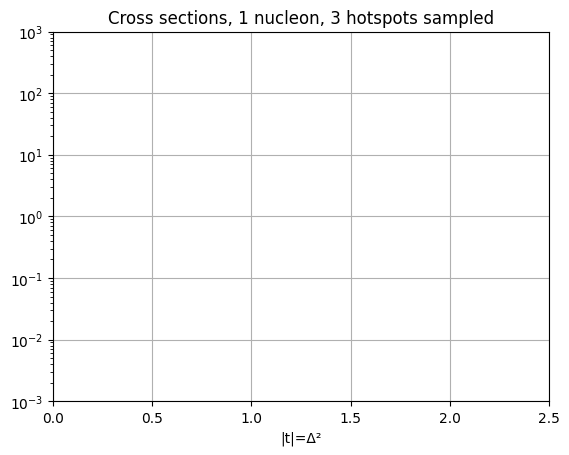

In [4]:
plt.title("Cross sections, 1 nucleon, 3 hotspots sampled")
plt.xlabel('|t|=Δ²')
plt.grid()
plt.xlim(0, 2.5)
plt.yscale('log')
plt.ylim(1.0e-3, 1.0e3)
plt.errorbar(cs_results[0]['t'], cs_results[0]['Inco'])
#plt.semilogy(cs_results[0][0], cs_results[0][3])
plt.show()

In [ ]:
print("finished")

finished
